In [1]:
! uv pip install -U langchain-tavily

Using Python 3.10.9 environment at: F:\code\ai\langgraph-learn\.venv
Resolved 43 packages in 2.86s
Audited 43 packages in 0.25ms


In [2]:
from dotenv import load_dotenv
load_dotenv()


True

## 定义Tool

In [3]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

## 定义Graph

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
! uv pip install -U "langchain[openai]"

Using Python 3.10.9 environment at: F:\code\ai\langgraph-learn\.venv
Resolved 39 packages in 2.74s
Audited 39 packages in 0.15ms


### llm绑定tools
这一步是让llm知道有哪些工具可以使用

In [6]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(model="qwen-plus-latest",base_url="https://dashscope.aliyuncs.com/compatible-mode/v1", 
        api_key=os.getenv("DASHSCOPE_API_KEY"),
        temperature=0)

llm_with_tools = llm.bind_tools(tools)

In [7]:
def chatbot_node(state: State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

graph_builder.add_node("chatbot", chatbot_node)

## 创建tool函数
graph中的运行单元都是一个node，以函数的形式存在，tool也不例外,所以要创建一个函数来运行这个tool。
为此langgraph的prebuilt包下封装了一个ToolNode

In [8]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## 创建conditional_edges
这是一个条件路由，根据state来判断下一个node。
为此langgraph prebuild包下也提供了一个tools_condition

In [9]:
from langgraph.graph import END


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

## 可视化graph
您可以使用 get_graph 方法和其中一种“draw”方法（例如 draw_ascii 或 draw_png 来可视化图形。每种 draw 方法都需要额外的依赖项。

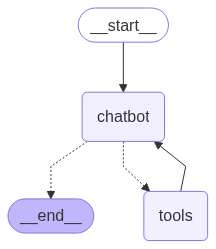

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 运行chatbot

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value)

In [12]:
stream_graph_updates("你知道LangGraph吗？")

Assistant: {'messages': AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4a1a165c28f74438a0d019', 'function': {'arguments': '{"query": "LangGraph"}', 'name': 'tavily_search'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 1132, 'total_tokens': 1154, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-latest', 'system_fingerprint': None, 'id': 'chatcmpl-a4754939-df93-9f90-8392-e77b8a367e9a', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e815345a-01d0-4252-ac39-957469590247-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'LangGraph'}, 'id': 'call_4a1a165c28f74438a0d019', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1132, 'output_tokens': 22, 'total_tokens': 1154, 'input_token_details': {}, 'output_token_details': {}})}
Assistant: {'messages': [ToolMessage(content='{"query": "LangGraph", "fol